<a href="https://colab.research.google.com/github/SamanMansoor/Data-Science/blob/main/Covid_19_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import mean
from IPython import display
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
import os
#from tensorflow.keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Conv2D
#from keras.layers import MaxPooling2D
#from keras.layers import Dense
#import math
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
from keras.layers import Flatten
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from PIL import ImageFilter

height, width = 224, 224
batch_size=64


def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'covid': 0, 'Normal': 1,'viral': 2}
    )
    return generator

TRAINING_DIR = '/content/covid/train'
TESTING_DIR = '/content/covid/test'

train_generator = generate_data(TRAINING_DIR)
test_generator = generate_data(TESTING_DIR)

total_image = np.concatenate([train_generator.labels,test_generator.labels])

print('\n\n',{'covid_cases':len(np.where(total_image==0)[0]),
      'normal_cases':len(np.where(total_image==1)[0]),
             'viral_cases':len(np.where(total_image==2)[0])})

Found 181 images belonging to 3 classes.
Found 46 images belonging to 3 classes.


 {'covid_cases': 137, 'normal_cases': 0, 'viral_cases': 90}


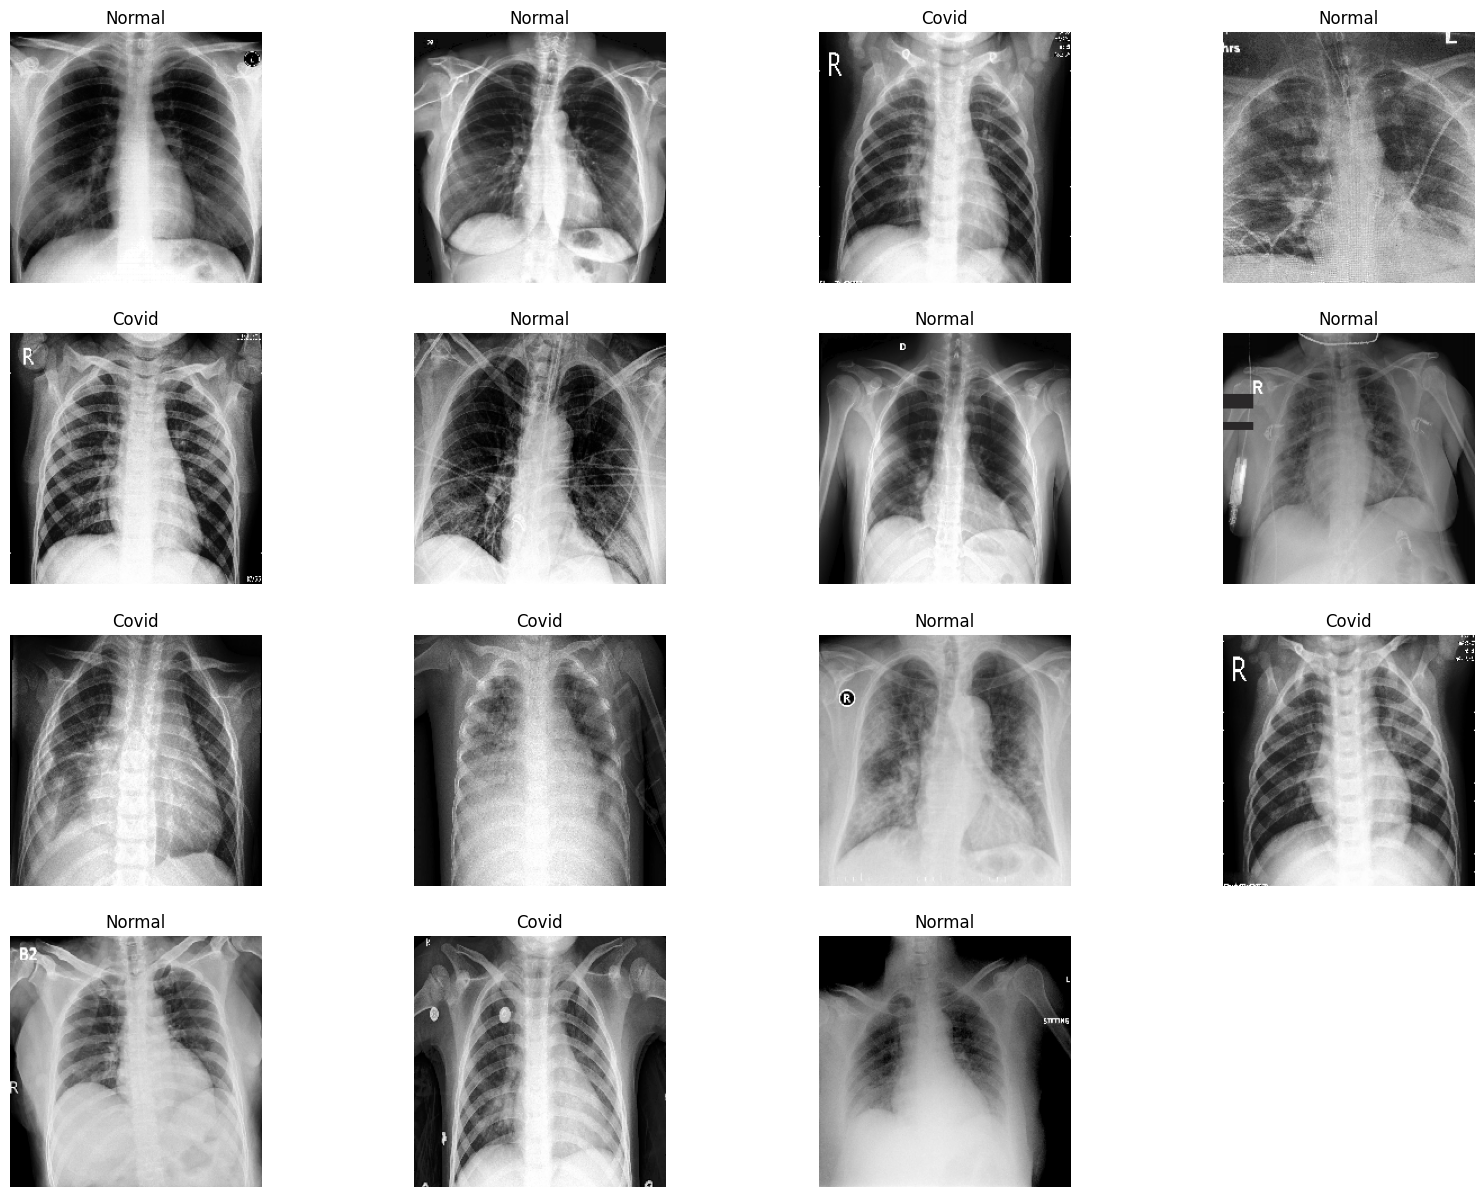

In [ ]:
def image_plot(generator,image_numbers):
    img_feature = generator[0][0][:image_numbers]
    img_label = generator[0][1][:image_numbers]

    plt.figure(figsize=(20, 15))
    for i in range(image_numbers):
        ax = plt.subplot(math.ceil(image_numbers/4),4, i + 1)
        plt.imshow(img_feature[i])
        plt.title("Normal" if img_label[i] == 0 else "Viral Pneumonia" if img_label[i] == 1 else "Covid")
        plt.axis("off")

image_plot(train_generator,15)

In [ ]:
import numpy as np

def prep_pixels(train_generator, test_generator):
    # convert from integers to floats
    train_samples = len(train_generator.filenames)
    test_samples = len(test_generator.filenames)

    train_shape = train_generator.image_shape
    test_shape = test_generator.image_shape

    train_data = np.zeros((train_samples, *train_shape), dtype='float32')
    test_data = np.zeros((test_samples, *test_shape), dtype='float32')

    for i in range(train_samples):
        train_data[i] = train_generator.next()[0][0] / 255.0
  
    for i in range(test_samples):
        test_data[i] = test_generator.next()[0][0] / 255.0

    return train_data, test_data

# prepare pixel data
train_norm, test_norm = prep_pixels(train_generator, test_generator)


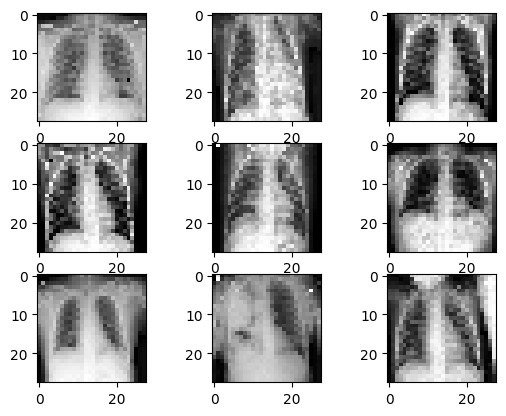

In [ ]:
def data_augmentation(X_train, y_train):
    datagen = ImageDataGenerator()
    # fit parameters from data
    datagen.fit(X_train)
    # configure batch size and retrieve one batch of images
    os.makedirs('images', exist_ok=True)
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9, save_to_dir='images', save_prefix='aug', save_format='png'):
        # create a grid of 3x3 images
        for i in range(0, 9):
            pyplot.subplot(330 + 1 + i)
            pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
        # show the plot
        pyplot.show()
        break
    return X_batch, y_batch
trainX_aug, trainY_aug = data_augmentation(train_norm, train_generator.classes)

    # concatenate original plus synthetic
trainX_final = np.concatenate((train_norm, trainX_aug), axis=0)
trainY_final = np.concatenate((train_generator.classes, trainY_aug), axis=0)


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing

tf.keras.backend.clear_session()
input_shape = (height, width, 3)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False

model_vgg16 = tf.keras.Sequential()
model_vgg16.add(base_model)
model_vgg16.add(tf.keras.layers.GlobalAveragePooling2D())

model_vgg16.add(tf.keras.layers.Flatten())
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))
model_vgg16.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg16.add(tf.keras.layers.Dropout(0.5))

model_vgg16.add(tf.keras.layers.Dense(3, activation='softmax'))

model_vgg16.compile(loss='SparseCategoricalCrossentropy', 
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['acc'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/vgg16_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=5)

callbacks_list = [checkpoint,early]

history = model_vgg16.fit(
        train_generator,
        validation_data = test_generator,
        #steps_per_epoch=10,
        epochs=10, 
        shuffle=False, 
        verbose=True,
        callbacks=callbacks_list)

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 1.1473 - acc: 0.4420 
Epoch 1: acc improved from -inf to 0.44199, saving model to model/vgg16_best.h5
3/3 [==============================] - 145s 52s/step - loss: 1.1473 - acc: 0.4420 - val_loss: 0.7423 - val_acc: 0.5652
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.7594 - acc: 0.6188 
Epoch 2: acc improved from 0.44199 to 0.61878, saving model to model/vgg16_best.h5
3/3 [==============================] - 144s 52s/step - loss: 0.7594 - acc: 0.6188 - val_loss: 0.6359 - val_acc: 0.5652
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.7048 - acc: 0.5967 
Epoch 3: acc did not improve from 0.61878
3/3 [==============================] - 128s 45s/step - loss: 0.7048 - acc: 0.5967 - val_loss: 0.5776 - val_acc: 0.6304
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 0.6595 - acc: 0.5967 
Epoch 4: acc did not improve from 0.61878
3/3 [==============================] - 144s 

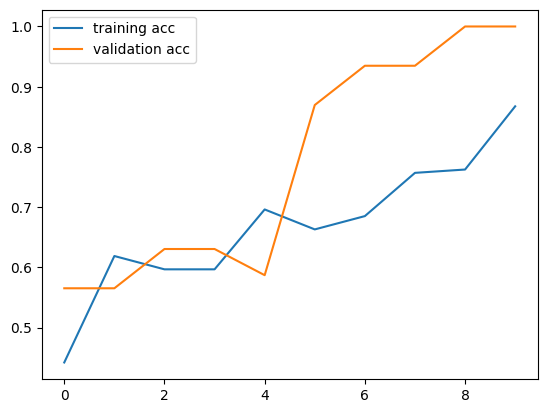

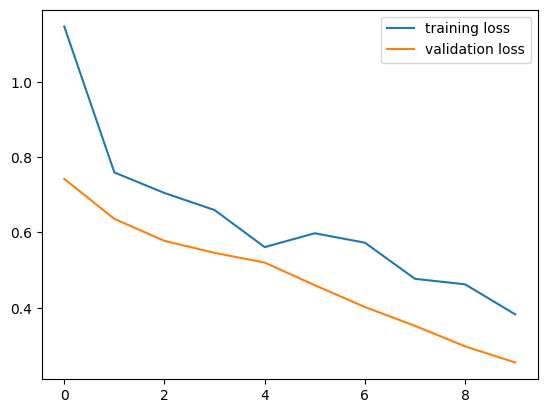

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Evaluate the model on the test data
test_loss, test_acc = model_vgg16.evaluate(test_generator, verbose=0)

# Generate predictions
num_test_samples = test_generator.samples
predictions = model_vgg16.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names, labels=np.unique(predicted_labels))

# Print the classification report
print(report)

1/1 [==============================] - 28s 28s/step
              precision    recall  f1-score   support

       covid       0.58      0.58      0.58        26
      Normal       0.45      0.45      0.45        20

    accuracy                           0.52        46
   macro avg       0.51      0.51      0.51        46
weighted avg       0.52      0.52      0.52        46



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 2, does not match size of target_names, 3
  warnings.warn(
